# Compare Tissues

In [3]:
library(ggplot2)
library(forcats)
library(tidyverse)
suppressPackageStartupMessages(library(tidyverse))
library(ggrepel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ dplyr   1.0.8
✔ readr   2.1.2     ✔ stringr 1.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
source('../../prj_helpers.R')

In [5]:
# Load results of previous analyses

In [6]:
results_paths = c(
    adrenal = "../..//08-simple-de-by-tissue/01-Adrenal/output/adrenal__infected_vs_uninfected.de.csv",
    spleen = "../..//08-simple-de-by-tissue/02-Spleen/output/spleen.de.csv",
    lymph_node_ax_r = "../..//08-simple-de-by-tissue/03-LymphNode_AX_R/output/LN_AX_R.de.csv",
    lymph_node_ing_l = "../..//08-simple-de-by-tissue/04-LymphNode_ING_L/output/LN_ING_L.de.csv",
    lymph_node_mes = "../..//08-simple-de-by-tissue/05-LymphNode_MES/output/LN_MES.de.csv",
    kidney = "../..//08-simple-de-by-tissue/06-Kidney/output/Kidney.de.csv",
    # liver is early /late
    #liver = "../..//08-simple-de-by-tissue/07-Liver/output/Liver.de.csv",
    brain_gray = "../..//08-simple-de-by-tissue/08-Brain_Brain-Gr/output/BrainGray.de.csv",
    sex_organ_ovary = "../..//08-simple-de-by-tissue/10-SexOrgan_Ovary/output/SexOrgan_Ovary.de.csv",
    sex_organ_sex_organ = "../..//08-simple-de-by-tissue/12-SexOrgan_SexOrgan/output/SexOrgan_SexOrgan.de.csv",
    skin_rash = "../..//08-simple-de-by-tissue/13-Skin_Rash/output/Skin_Rash.de.csv",
    #lung = "/home/nbarkas/disk2/ebov_bulk_rna_seq/proc_20210329/08-simple-de-by-tissue/14-Lung/output/Lung.de.csv",
    skin_non_rash = "../..//08-simple-de-by-tissue/15-Skin_NonRash/output/Skin_NonRash.de.csv",
    brain_white = "../..//08-simple-de-by-tissue/16-Brain_Brain-Wh/output/Brain_White.de.csv"
)



Warning message in file(file, "rt"):
“cannot open file '../05-sample_overview/full_tissue_color.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [7]:
results.all.tissues <- lapply(results_paths, read.csv)

In [7]:
de.genes.all.tissues <- lapply(results.all.tissues, function(x) {
    xp <- x[NA2FALSE(x$padj < 0.05),]
    unique(xp$Geneid)
})

In [8]:
n.de.per.tissue <- unlist(lapply(de.genes.all.tissues, length))
n.de.df.plot <- data.frame(
    tissue = names(n.de.per.tissue),
    n.genes = n.de.per.tissue
)

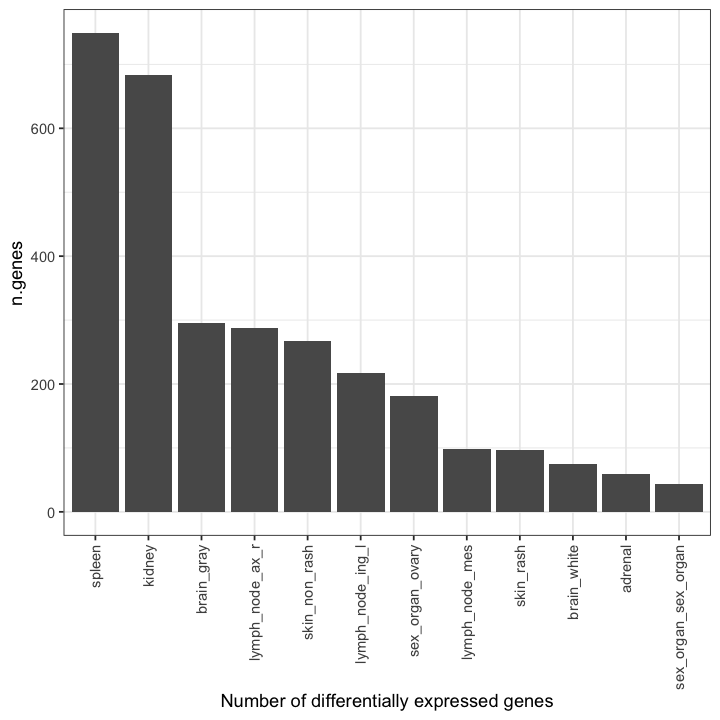

In [9]:
options(repr.plot.width=6, repr.plot.height=6)

ggplot(n.de.df.plot, aes(x=fct_reorder(tissue, desc(n.genes)),y=n.genes)) +
    geom_bar(stat='identity') + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    scale_x_discrete("Number of differentially expressed genes")

In [13]:
ggsave('output/n_de_genes.png',w=10,h=10)

In [11]:
tissues.expressed.cutoff <- 2
recurrent.genes <- names(which(sort(table(unlist(de.genes.all.tissues)),decreasing = T) > tissues.expressed.cutoff))

In [12]:
length(recurrent.genes)

[1] 241

In [13]:
recurrent.genes <- recurrent.genes[recurrent.genes != '']

In [14]:
length(recurrent.genes)

[1] 241

In [1]:
head(recurrent.genes)

ERROR: Error in head(recurrent.genes): object 'recurrent.genes' not found


In [16]:
saveRDS(recurrent.genes,'recurrent.genes.rds')

In [17]:
# Save recurrent Genes as a table

In [18]:
write.csv(x = gene_map[gene_map$Geneid %in% recurrent.genes,], file='output/recurrent_genes.csv')

ERROR: Error in is.data.frame(x): object 'gene_map' not found


In [19]:
tmp1 <- lapply(results.all.tissues, function(x) {
    rownames(x) <- x$Geneid
    x[recurrent.genes,]$log2FoldChange
})
tmp2 <- do.call(cbind, tmp1)
rownames(tmp2) <- recurrent.genes

In [1]:
# Create a gene map
gene_map <- results.all.tissues[[1]][,c('Geneid','external_gene_name')]
head(gene_map)

ERROR: Error in eval(expr, envir, enclos): object 'results.all.tissues' not found


In [21]:
# Convert ens ids to gene names, if they can be converted. Keep as is otherwise
new.names <- sapply(rownames(tmp2), function(x) { 
    new.name <- gene_map[match(x, gene_map$Geneid),'external_gene_name']
    ifelse(new.name != '', new.name, x)
})
rownames(tmp2) <- new.names

In [22]:
head(new.names)

ENSMMUG00000001569.4   ENSMMUG00000003272.4   ENSMMUG00000005001.4 
              "IFI44L" "ENSMMUG00000003272.4"                "IFIT3" 
  ENSMMUG00000008505.4   ENSMMUG00000009602.4   ENSMMUG00000010314.4 
                "OAS2"                 "XAF1"                "HERC6"

In [23]:
# Run go on these genes

In [24]:
# Some tissue results for the metadata that the go function needs
adrenal.res.pp <- readRDS('../02-Spleen//res.spleen.pp.rds')
#lung.res.pp <- readRDS('../14-Lung/res.lung.pp.rds')

In [25]:
library(goseq)

Loading required package: BiasedUrn

Loading required package: geneLenDataBase





In [26]:
runMacaqueGO_from_genes <- function (genes, res, test.cats = c("GO:CC", "GO:BP", "GO:MF")) 
{
    gene.lengths <- res$Length
    names(gene.lengths) <- rownames(res)
    
    bias <- gene.lengths[names(genes)]

    pwf <- nullp(genes, "rheMac10", "ensGene", bias.data = bias)
    rownames(pwf) <- make.unique(nbHelpers::strpart(rownames(pwf), ".", 1, fixed = T))
    
    gene2cat <- getgo(genes = nbHelpers::strpart(names(genes), 
        split = ".", fixed = T, n = 1), genome = "rheMac10", 
        id = "ensGene", fetch.cats = test.cats)
    
    goseq_res1 <- goseq(pwf = pwf, genome = "rheMac10", gene2cat = gene2cat, test.cats = test.cats)
    
    invisible(goseq_res1)
}

In [27]:
z <- as.numeric(rownames(adrenal.res.pp) %in% names(new.names))
names(z) <- rownames(adrenal.res.pp)

In [28]:
table(z)

z
    0     1 
35154   241 

Warning message in pcls(G):
“initial point very close to some inequality constraints”
Warning message:
“replacing previous import ‘Rcpp::prompt’ by ‘utils::prompt’ when loading ‘nbHelpers’”
Warning message:
“replacing previous import ‘Rcpp::.DollarNames’ by ‘utils::.DollarNames’ when loading ‘nbHelpers’”
Warning message:
“replacing previous import ‘Matrix::tail’ by ‘utils::tail’ when loading ‘nbHelpers’”
Warning message:
“replacing previous import ‘Matrix::head’ by ‘utils::head’ when loading ‘nbHelpers’”
Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicat

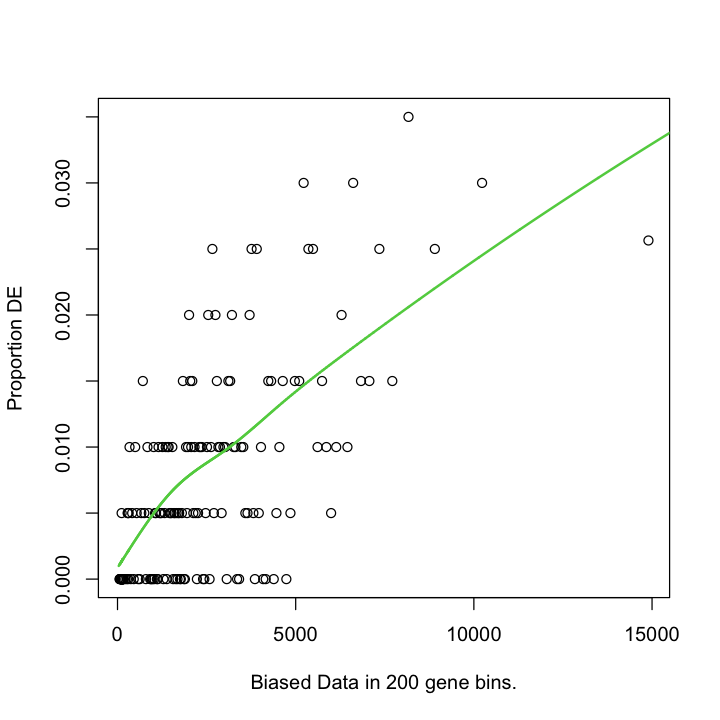

In [29]:
common.genes.go <- runMacaqueGO_from_genes(z, adrenal.res.pp)

In [30]:
head(common.genes.go)

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
2874,GO:0006955,1.064531e-48,1,68,616,immune response,BP
11155,GO:0051707,2.639306e-42,1,56,453,response to other organism,BP
8896,GO:0043207,3.144062e-42,1,56,455,response to external biotic stimulus,BP
3729,GO:0009607,1.269964e-41,1,56,466,response to biotic stimulus,BP
2871,GO:0006952,1.488077e-41,1,59,543,defense response,BP
9297,GO:0044419,1.661938e-39,1,56,499,biological process involved in interspecies interaction between organisms,BP


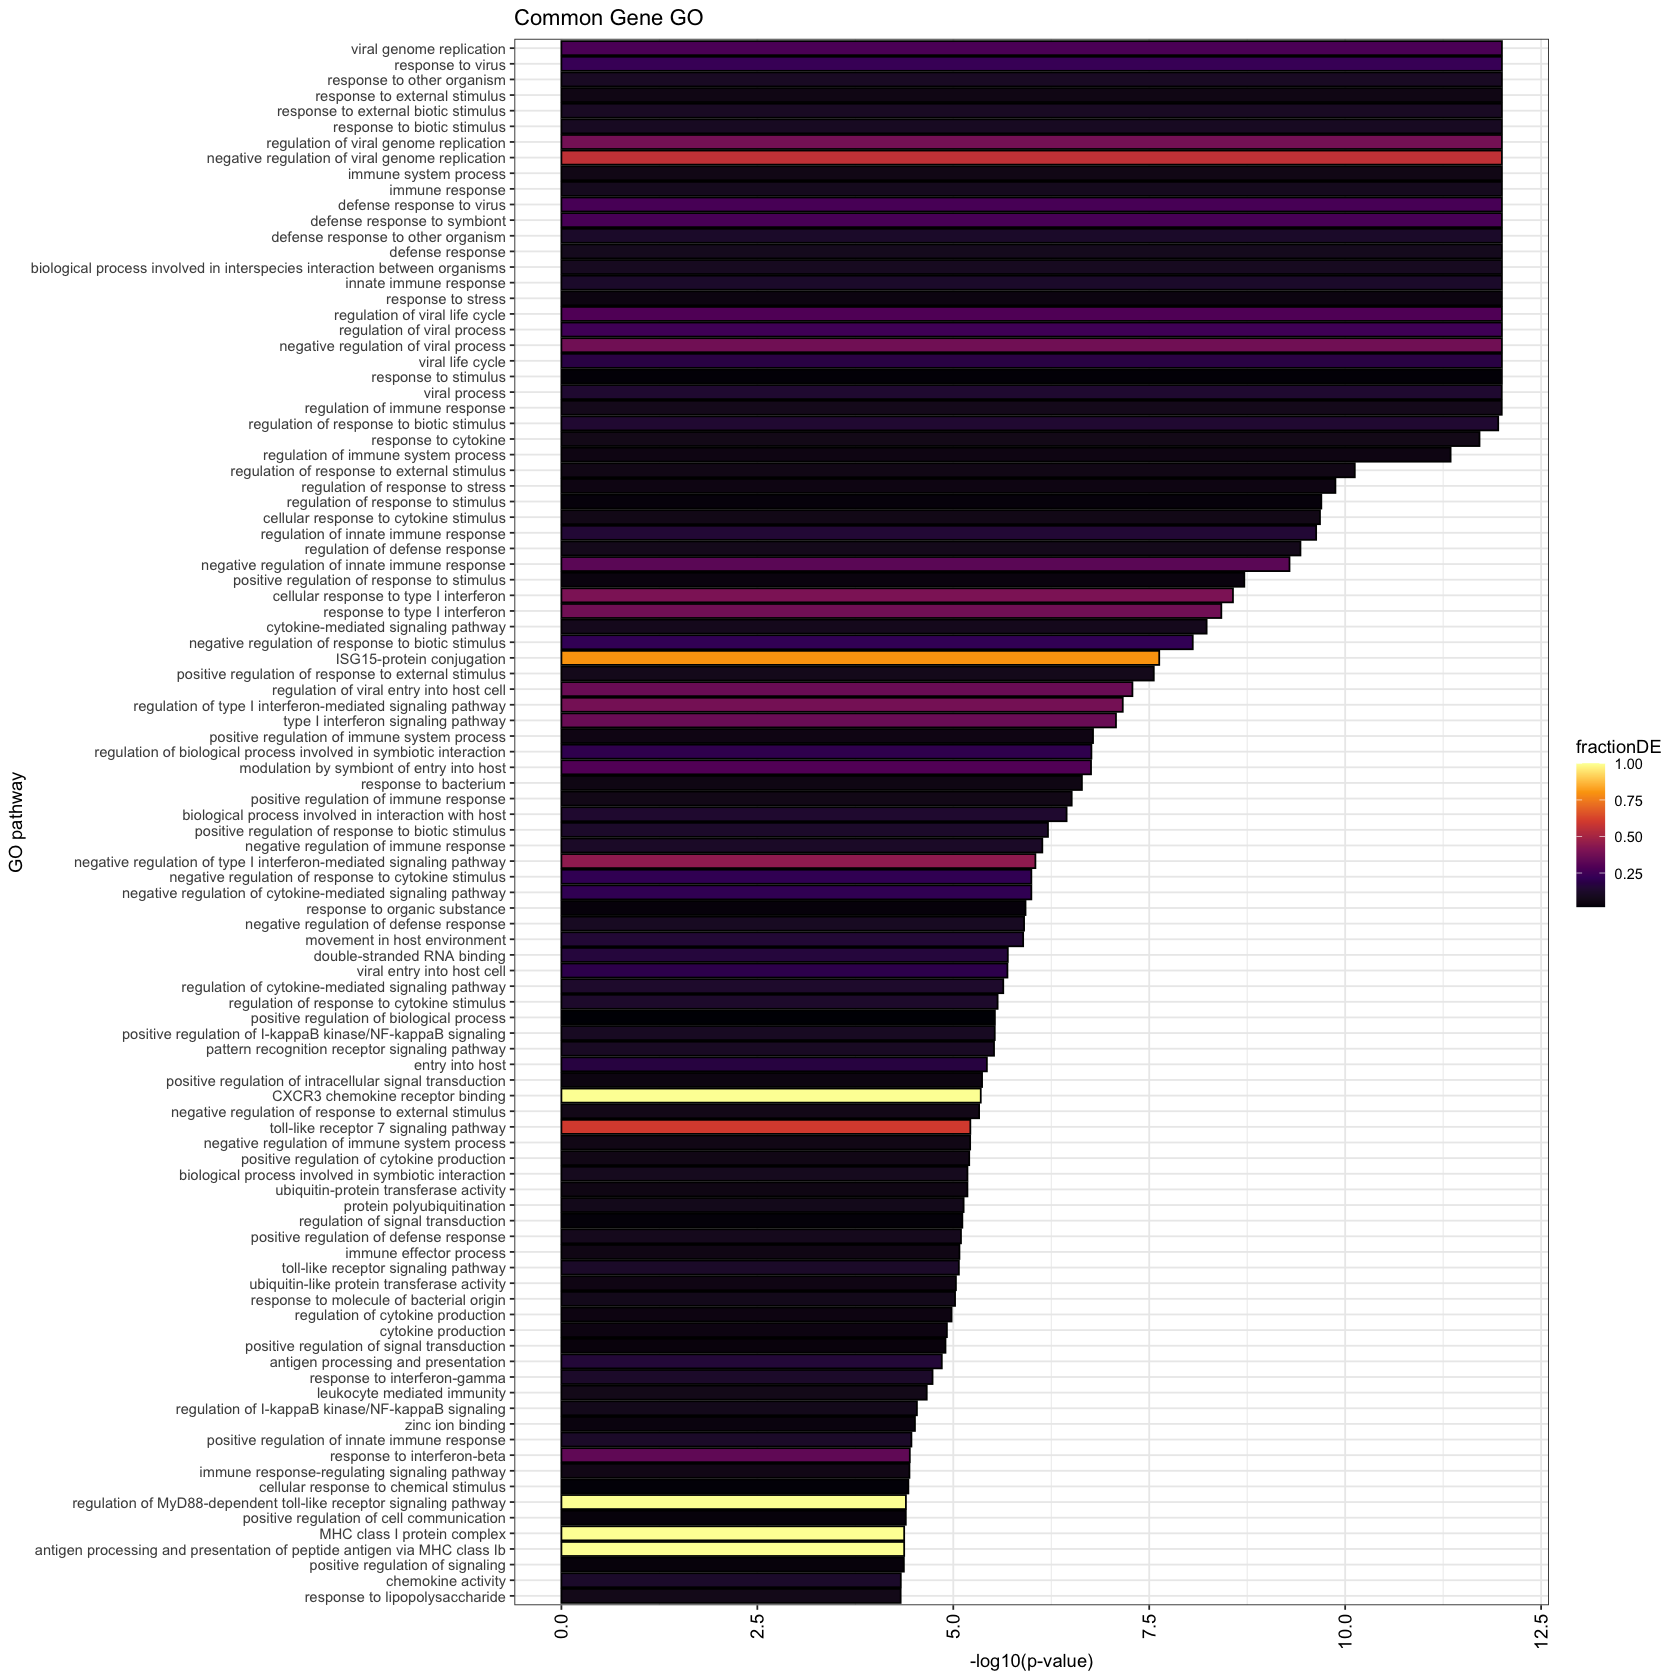

In [42]:
options(repr.plot.width=14, repr.plot.height=14)

common.genes.go %>%
    mutate(fractionDE=numDEInCat/numInCat) %>%
    mutate(scaledPval= -log10(over_represented_pvalue+1e-12) ) %>%
    head(n=100) %>% 
    ggplot(aes(x=reorder(term, (scaledPval) ),fill=fractionDE,y=scaledPval)) + 
    geom_bar(stat='identity',color='black') +
    theme_bw() + 
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, color='black', size=11)) +
    scale_x_discrete(name="GO pathway") +
    scale_y_continuous(name="-log10(p-value)") + 
    scale_fill_viridis_c(option='B') +
    ggtitle("Common Gene GO") + coord_flip()

In [33]:
ggsave('output/common_go_response.png',w=7,h=24)

In [31]:
common.genes.go %>%
    mutate(fractionDE=numDEInCat/numInCat) %>%
    mutate(scaledPval= -log10(over_represented_pvalue+1e-12) ) -> zzp
write.csv(zzp, "output/common.pathways.csv")

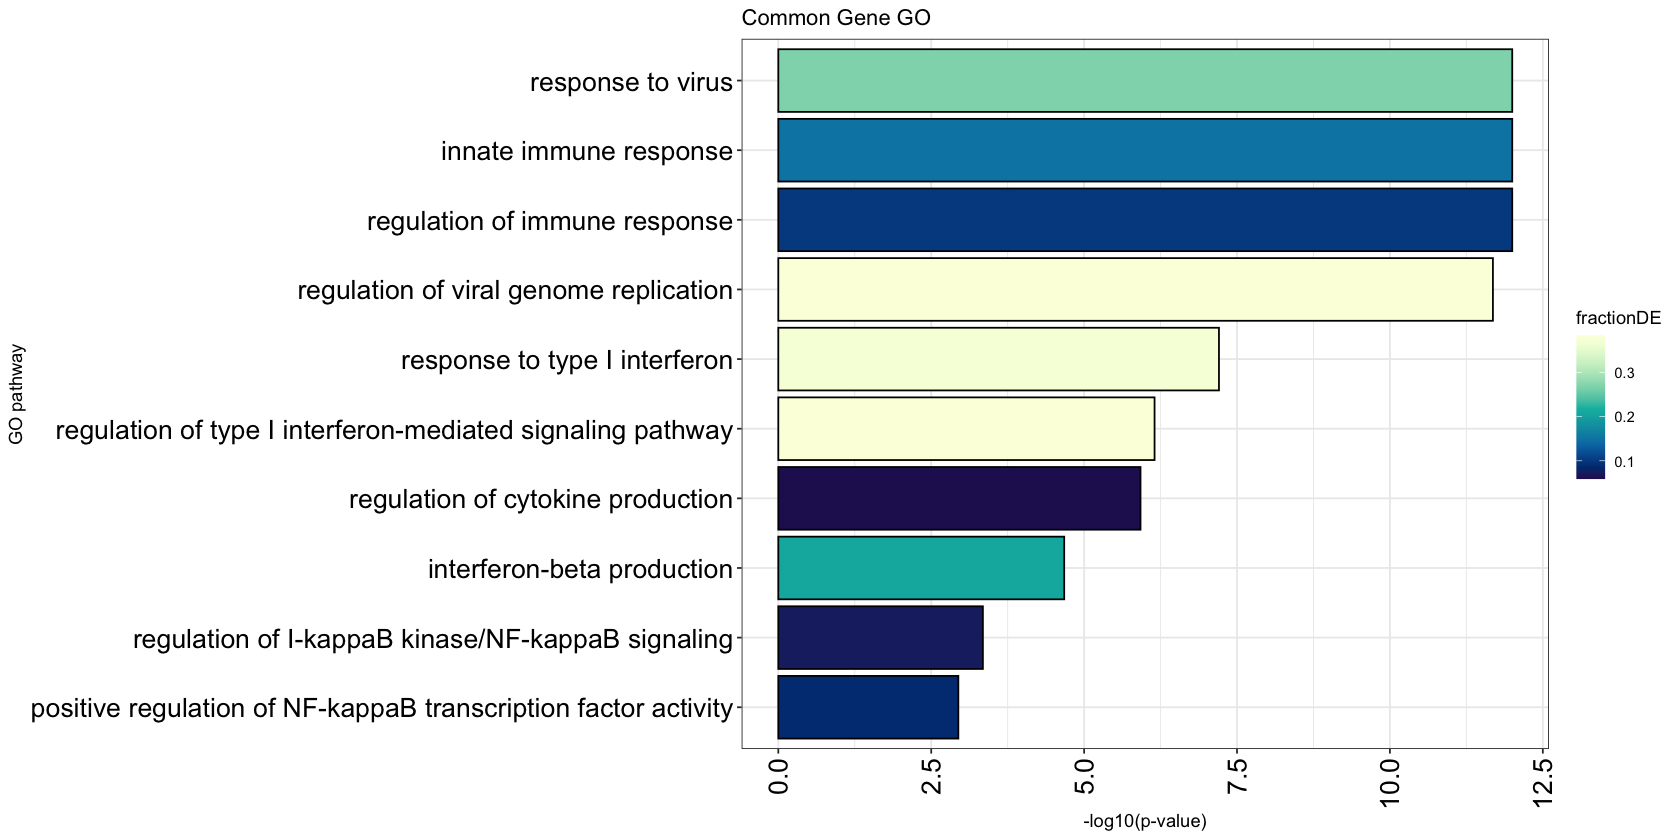

In [40]:
options(repr.plot.width=14, repr.plot.height=7)

select.pathways <- c("GO:0009615",
"GO:0045069",
"GO:0045087",
"GO:0034340",
"GO:0001817",
"GO:0051092",
"GO:0050776",
"GO:0043122",
"GO:0060338",
"GO:0032608")

common.genes.go %>%
    mutate(fractionDE=numDEInCat/numInCat) %>%
    mutate(scaledPval= -log10(over_represented_pvalue+1e-12) ) %>%
    filter(category %in% select.pathways) %>% 
    ggplot(aes(x=reorder(term, (scaledPval) ),fill=fractionDE,y=scaledPval)) + 
    geom_bar(stat='identity',color='black') +
    theme_bw() + 
    theme(
            axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, color='black', size=16),
            axis.text.y = element_text(color='black', size=16)
    ) +
    scale_x_discrete(name="GO pathway") +
    scale_y_continuous(name="-log10(p-value)") + 
scale_fill_gradientn(colours = hcl.colors(100, palette = "YlGnBu"), guide = "colourbar")+ 
    ggtitle("Common Gene GO") + coord_flip()

### Heatmap of recurrent genes

In [36]:
library(pheatmap)
library(viridis)

Loading required package: viridisLite



In [37]:
pheatmap(tmp2,show_rownames = TRUE, color= hcl.colors(100, palette = "Fall"), fontsize_row=6, filename='output/recurrent_genes.png')

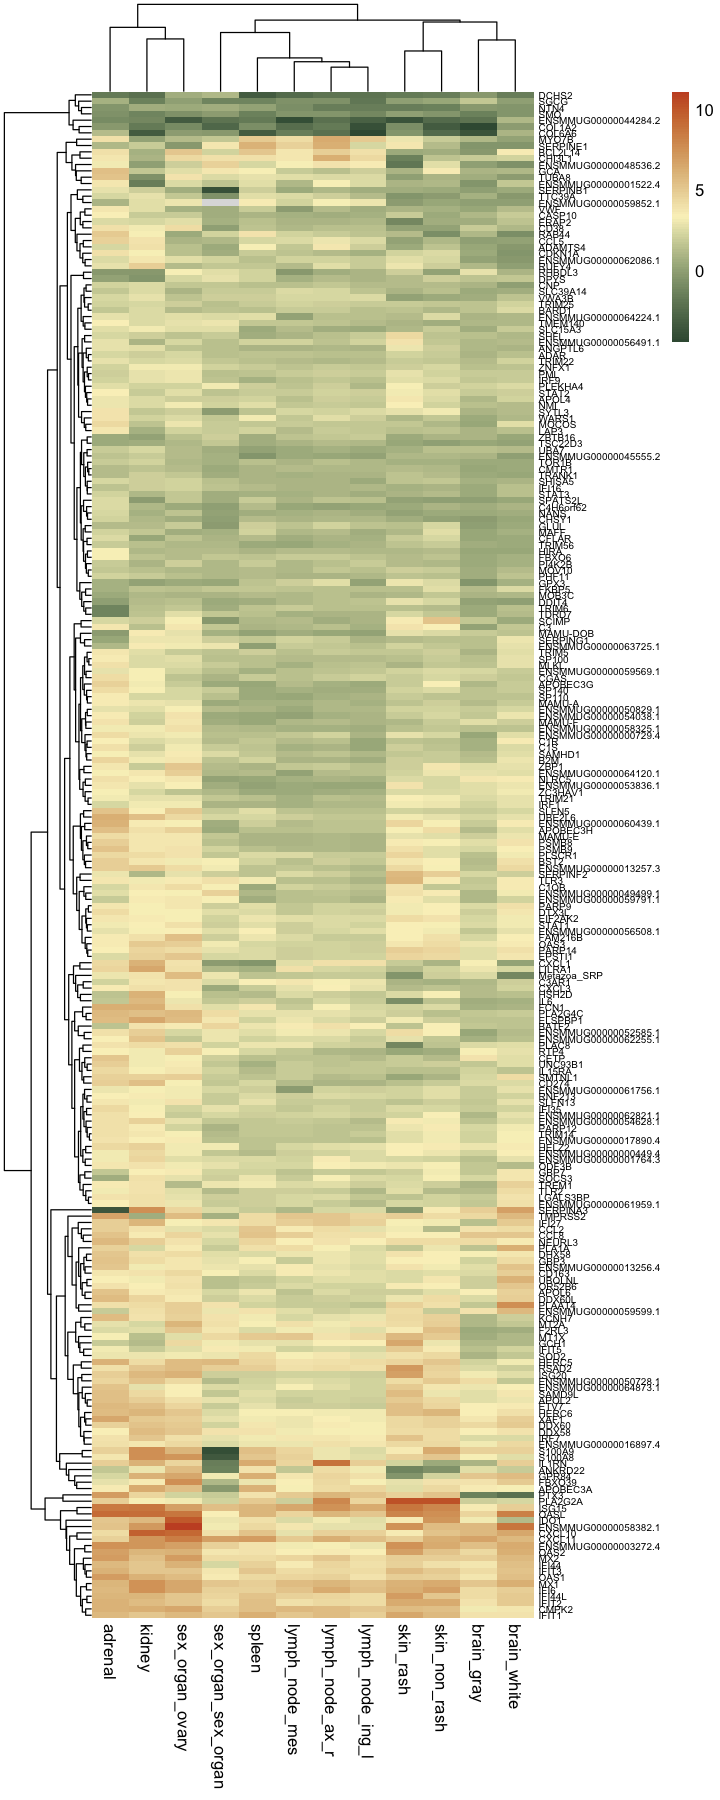

In [39]:
options(repr.plot.width=6, repr.plot.height=15)
pheatmap(tmp2,show_rownames = TRUE, color= hcl.colors(100, palette = "Fall"), fontsize_row=6)

# PCA of fold changes

## Prepare matrix

In [70]:
# Check if the names are in the same order
z <- lapply(results.all.tissues, function(x) {x$X})
all(z[[1]] == z[[2]])

[1] FALSE

In [71]:
# Put in order
results.all.tissues.o_gene <- lapply(results.all.tissues, function(x) {x[order(x$X),]})

In [72]:
all(results.all.tissues.o_gene[[1]]$X == results.all.tissues.o_gene[[2]]$X)

[1] TRUE

In [73]:
flc.mat <- do.call(cbind,lapply(results.all.tissues.o_gene, function(x) {x$log2FoldChange}))
rownames(flc.mat) <- results.all.tissues.o_gene[[1]]$X

In [74]:
flc.mat[is.na(flc.mat)] <- 0

In [75]:
flc.mat[1:3,1:3]

,adrenal,spleen,lymph_node_ax_r
ENSMMUG00000000001.4,0.4975436,-0.1794700,0.5442809
ENSMMUG00000000002.4,0.4348440,-0.2279602,1.2656310
ENSMMUG00000000005.4,1.5331613,-0.1966687,0.7392688


In [76]:
# pick genes de in at least one tissue
de.genes <- unique(unlist(lapply(results.all.tissues, function(x) {x$X[x$padj < 0.05]})))
de.genes <- de.genes[!is.na(de.genes)]
pca.lfc.sel <- prcomp(t(scale(flc.mat[de.genes,])))
plot.df <- data.frame(tissue=rownames(pca.lfc.sel$x),pca.lfc.sel$x[,1:5])
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(plot.df, aes(color=tissue, x=PC1, y=PC2)) + 
    geom_point(size=6) + 
    theme_bw() + 
    geom_label_repel(aes(label=tissue)) + 
    ggtitle('PCA of LogFoldChanges')

n.top.genes.per.pc <- 40

loaded.genes <- unique(c(
    head(names(sort(abs(pca.lfc.sel$rotation[,c('PC1')]),decreasing = T)),n=n.top.genes.per.pc),
    head(names(sort(abs(pca.lfc.sel$rotation[,c('PC2')]),decreasing = T)),n=n.top.genes.per.pc)
    ))

loading_scale <- 0.7e2
loaded.genes.df <- as.data.frame(pca.lfc.sel$rotation[loaded.genes,c('PC1','PC2')])

loaded.genes.df$symbol <- gene_map$external_gene_name[match(rownames(loaded.genes.df), gene_map$Geneid)]
ggplot(plot.df, aes(color=tissue, x=PC1, y=PC2)) + 
    theme_bw() + 
    geom_segment(
        alpha=0.5,
        arrow = arrow(),
        data=loaded.genes.df,
        aes(x=0,y=0,xend=PC1*loading_scale,yend=PC2*loading_scale),inherit.aes=F
    ) +   ggtitle('PCA of LogFoldChanges') +
    geom_label_repel(data=loaded.genes.df,aes(x=PC1*loading_scale,y=PC2*loading_scale,label=symbol),inherit.aes=F,max.overlaps=100) +
    geom_point(size=12, alpha=0.7) +
    geom_label_repel(aes(label=tissue)) +
    theme(legend.position = 'none')

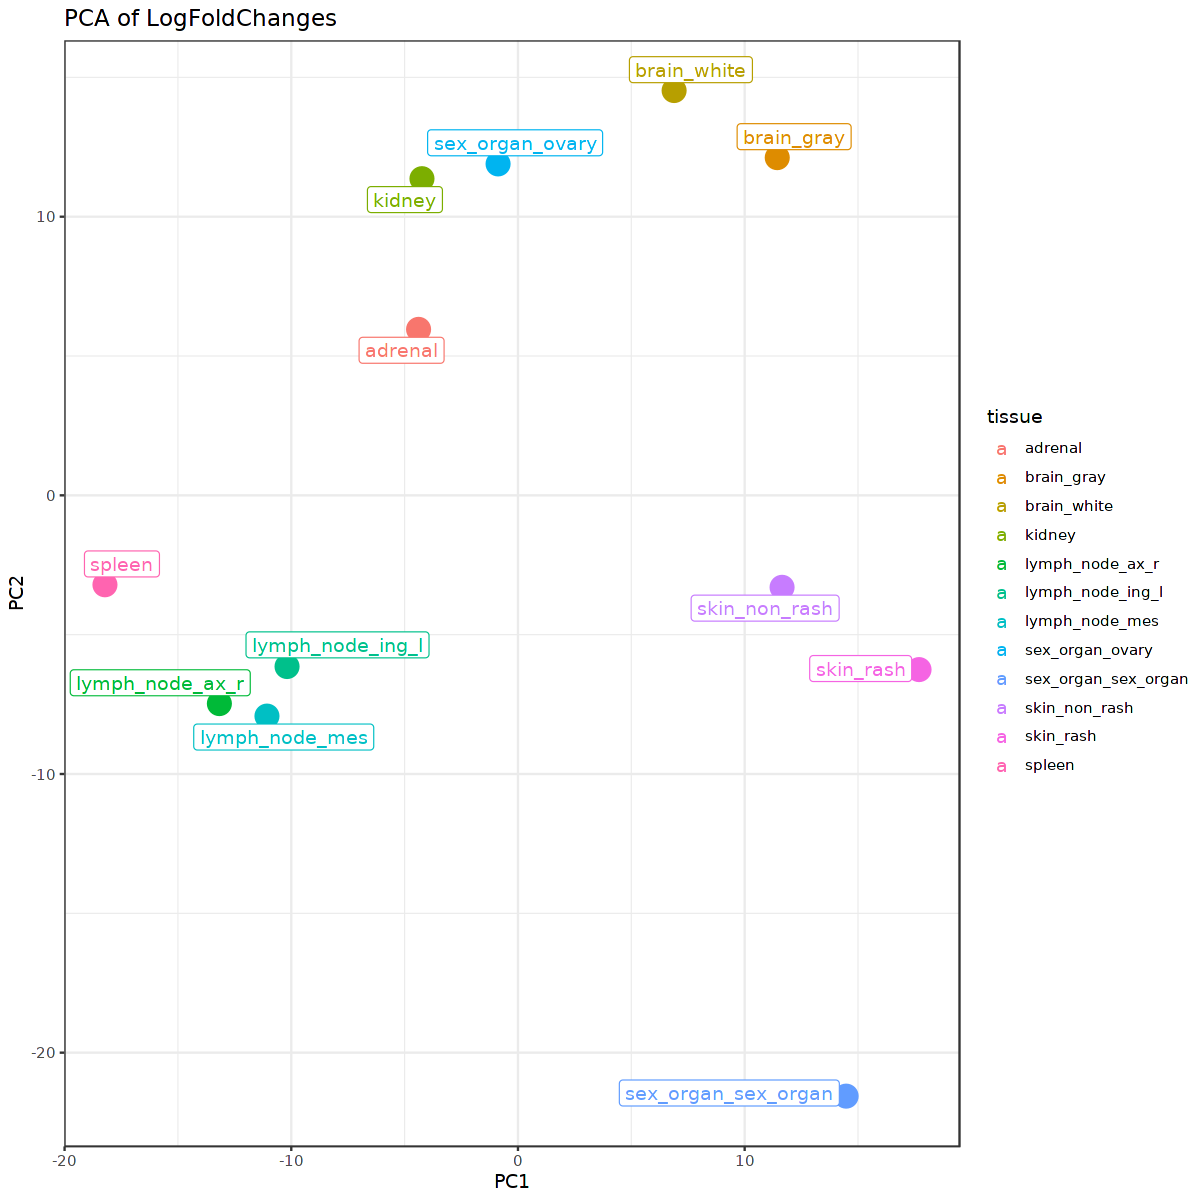

In [81]:
ggsave('output/pca_lfc.png',w=8,h=8)

In [82]:
# Show the genes weighted in these PCs

In [86]:
options(repr.plot.width = 15, repr.plot.height = 15)

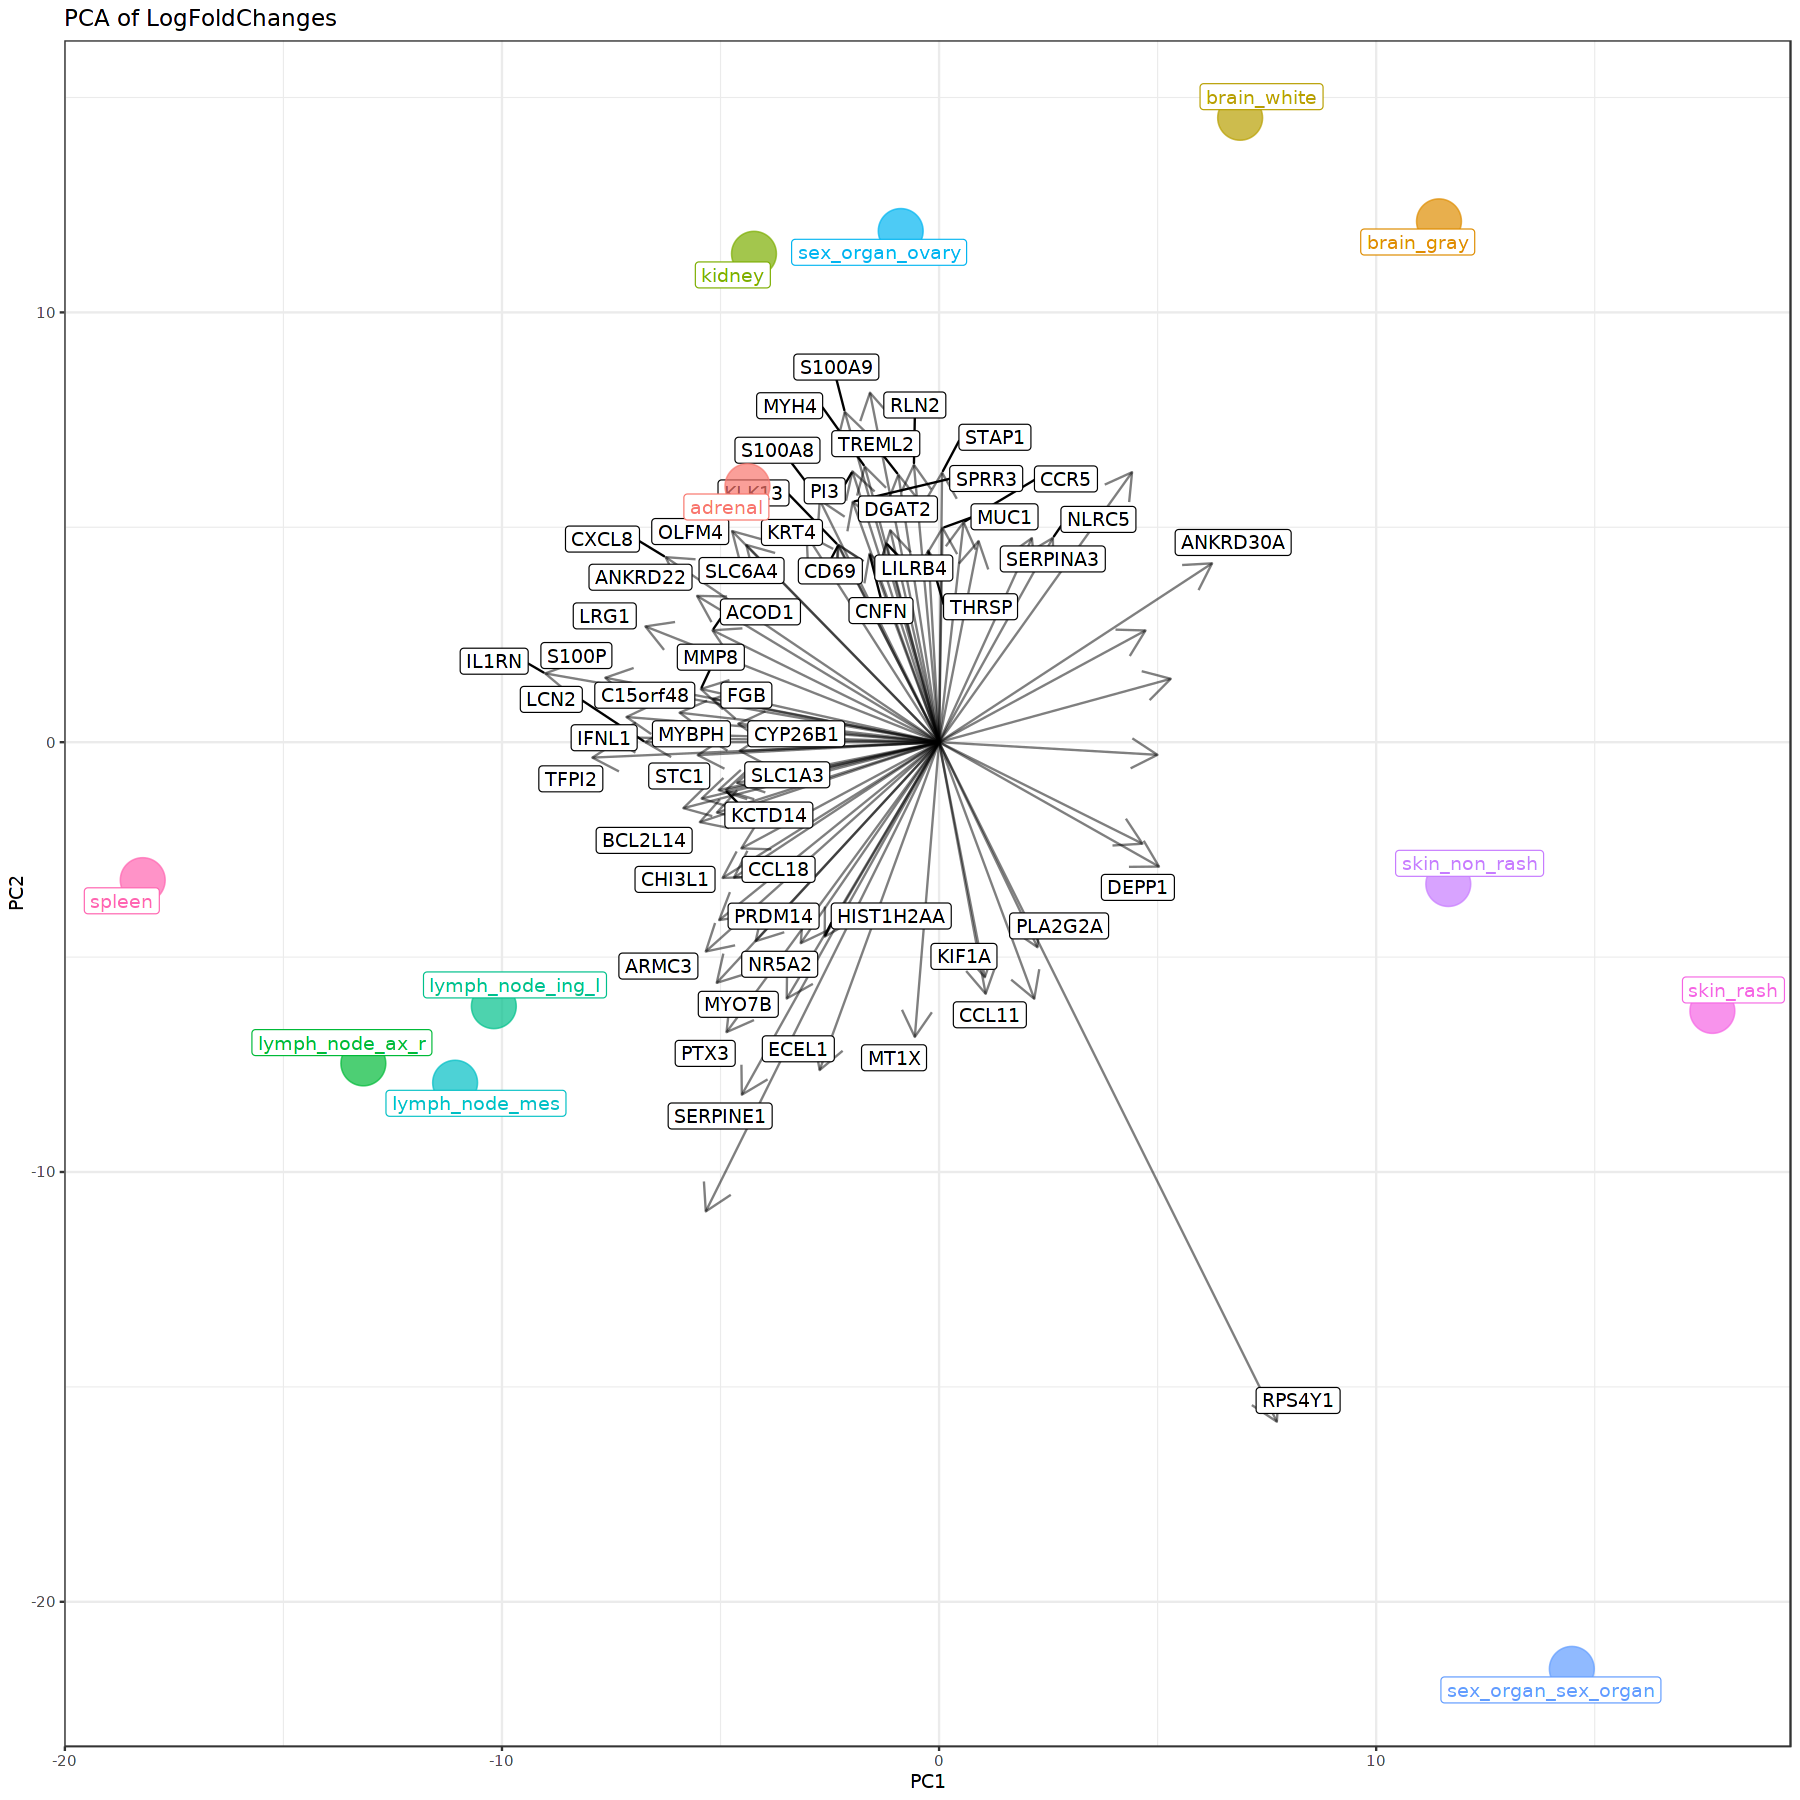

In [88]:
ggsave('output/pca_lfc_withloadings.png',w=10,h=10)

In [103]:
head(gene_map)

,Geneid,external_gene_name
,<chr>,<chr>
1,ENSMMUG00000015329.4,MX1
2,ENSMMUG00000044257.2,MX2
3,ENSMMUG00000012782.4,OAS1
4,ENSMMUG00000050757.1,ISG15
5,ENSMMUG00000008505.4,OAS2
6,ENSMMUG00000009602.4,XAF1


In [105]:
get_id_from_symbol <- function(symbol) { gene_map$Geneid[gene_map$external_gene_name == symbol]}

In [127]:
plot_gene_fcs <- function(gene) {
    tmp_df <- as.data.frame(flc.mat[get_id_from_symbol(gene),])
    colnames(tmp_df) <- c("fc")
    tmp_df$tissue <- rownames(tmp_df)
    ggplot(tmp_df, aes(x=tissue,y=fc, fill=tissue)) + geom_bar(stat='identity') + 
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=20))
        
}

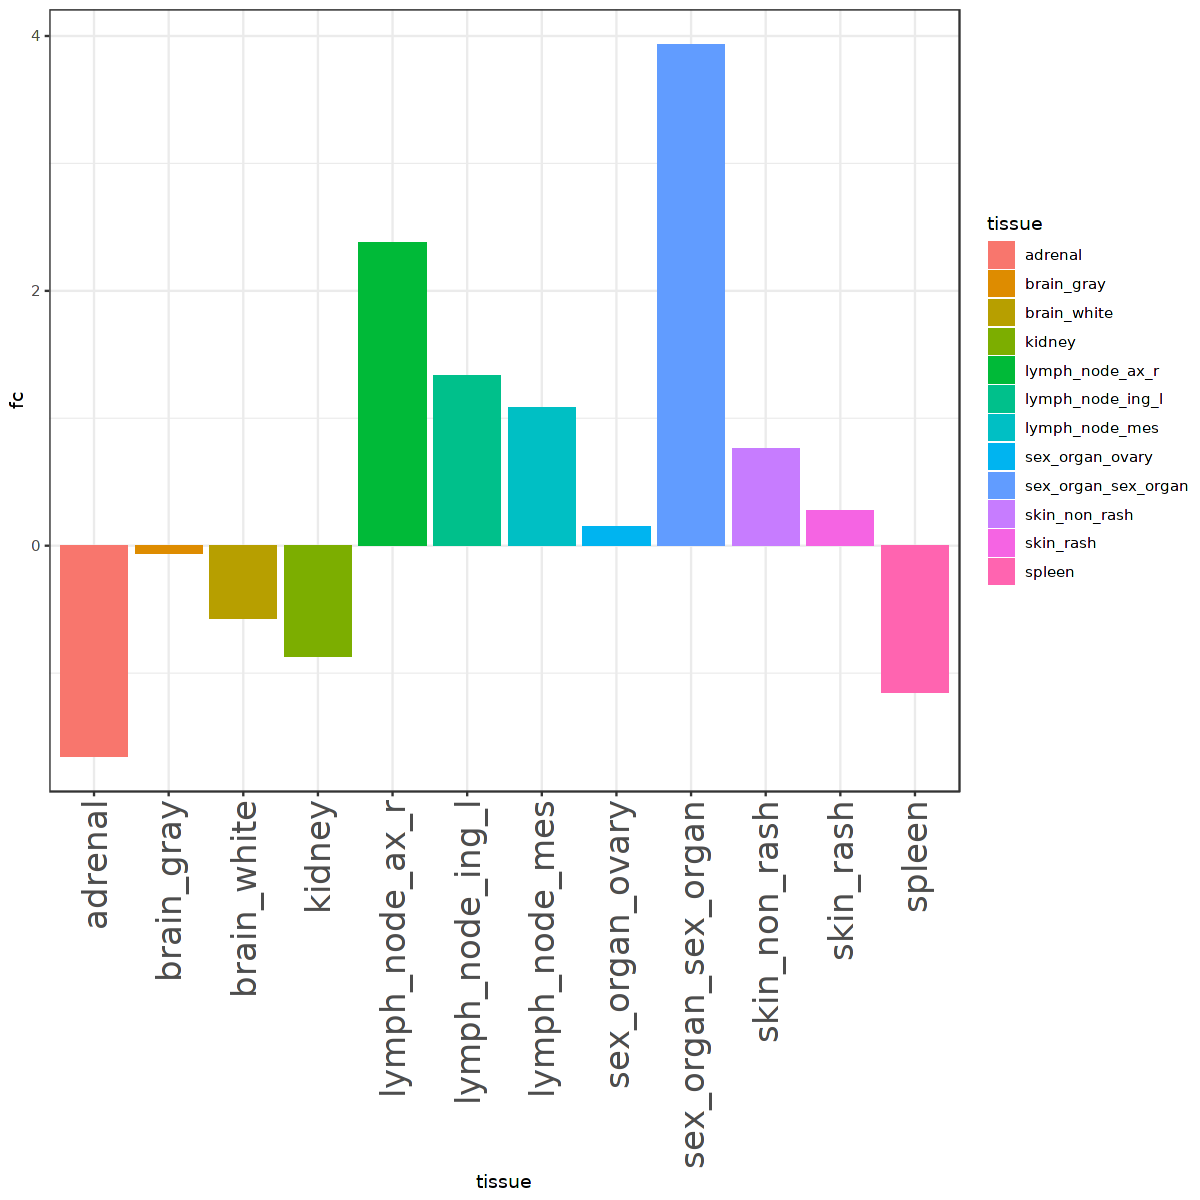

In [128]:
plot_gene_fcs('KIF1A')

## PC2 vs PC3

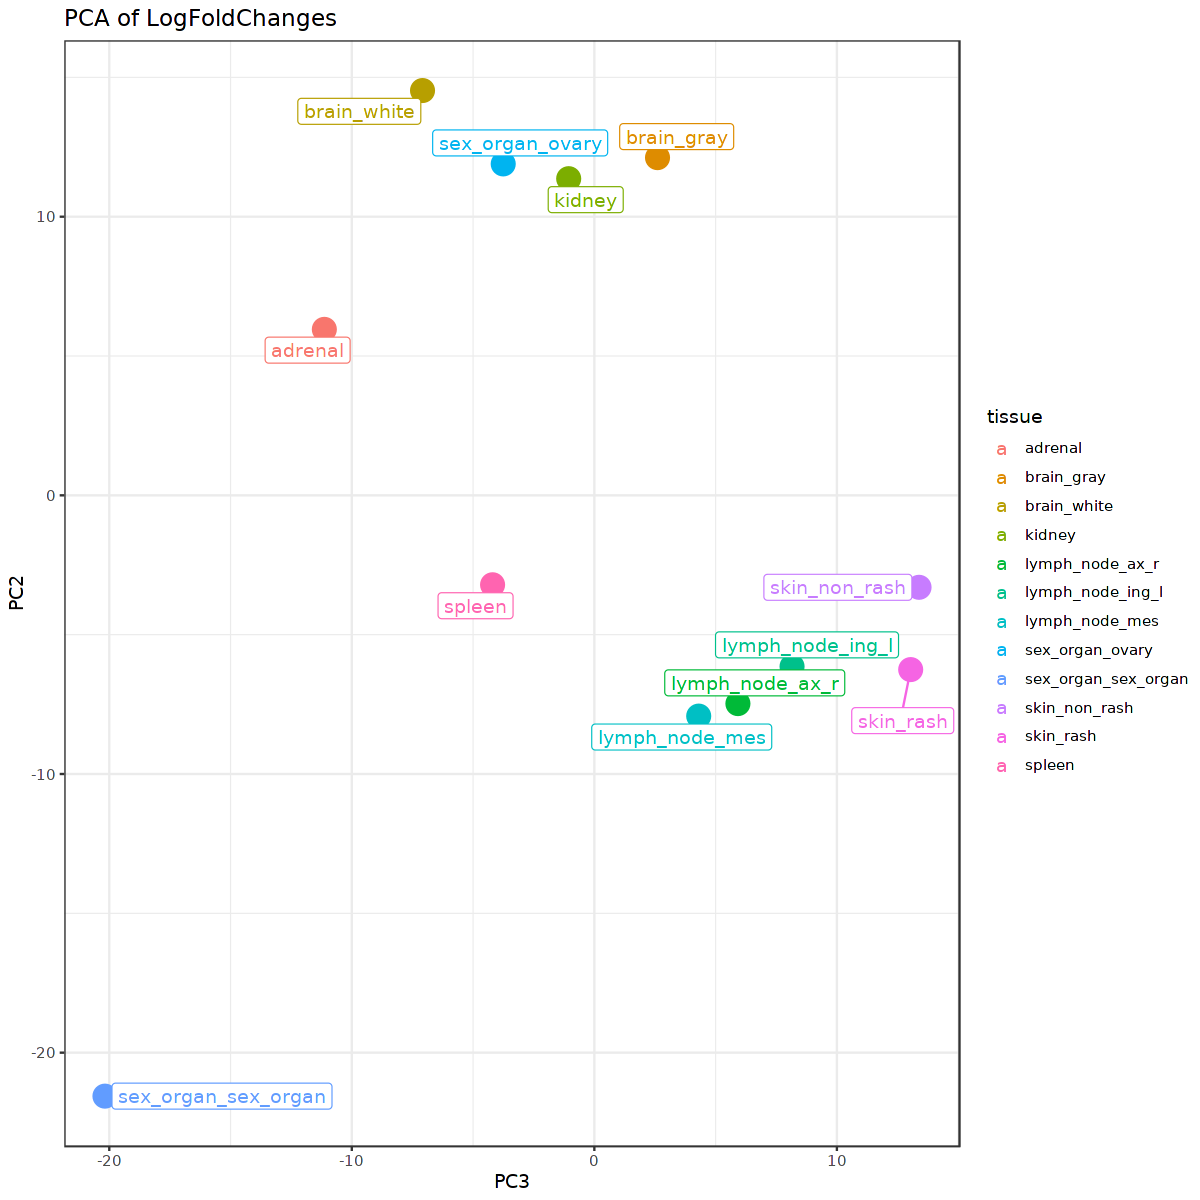

In [91]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(plot.df, aes(color=tissue, x=PC3, y=PC2)) + 
    geom_point(size=6) + 
    theme_bw() + 
    geom_label_repel(aes(label=tissue)) + 
    ggtitle('PCA of LogFoldChanges')

In [95]:
n.top.genes.per.pc <- 40

loaded.genes <- unique(c(
    head(names(sort(abs(pca.lfc.sel$rotation[,c('PC2')]),decreasing = T)),n=n.top.genes.per.pc),
    head(names(sort(abs(pca.lfc.sel$rotation[,c('PC3')]),decreasing = T)),n=n.top.genes.per.pc)
    ))

loading_scale <- 0.7e2
loaded.genes.df <- as.data.frame(pca.lfc.sel$rotation[loaded.genes,c('PC2','PC3')])

loaded.genes.df$symbol <- gene_map$external_gene_name[match(rownames(loaded.genes.df), gene_map$Geneid)]

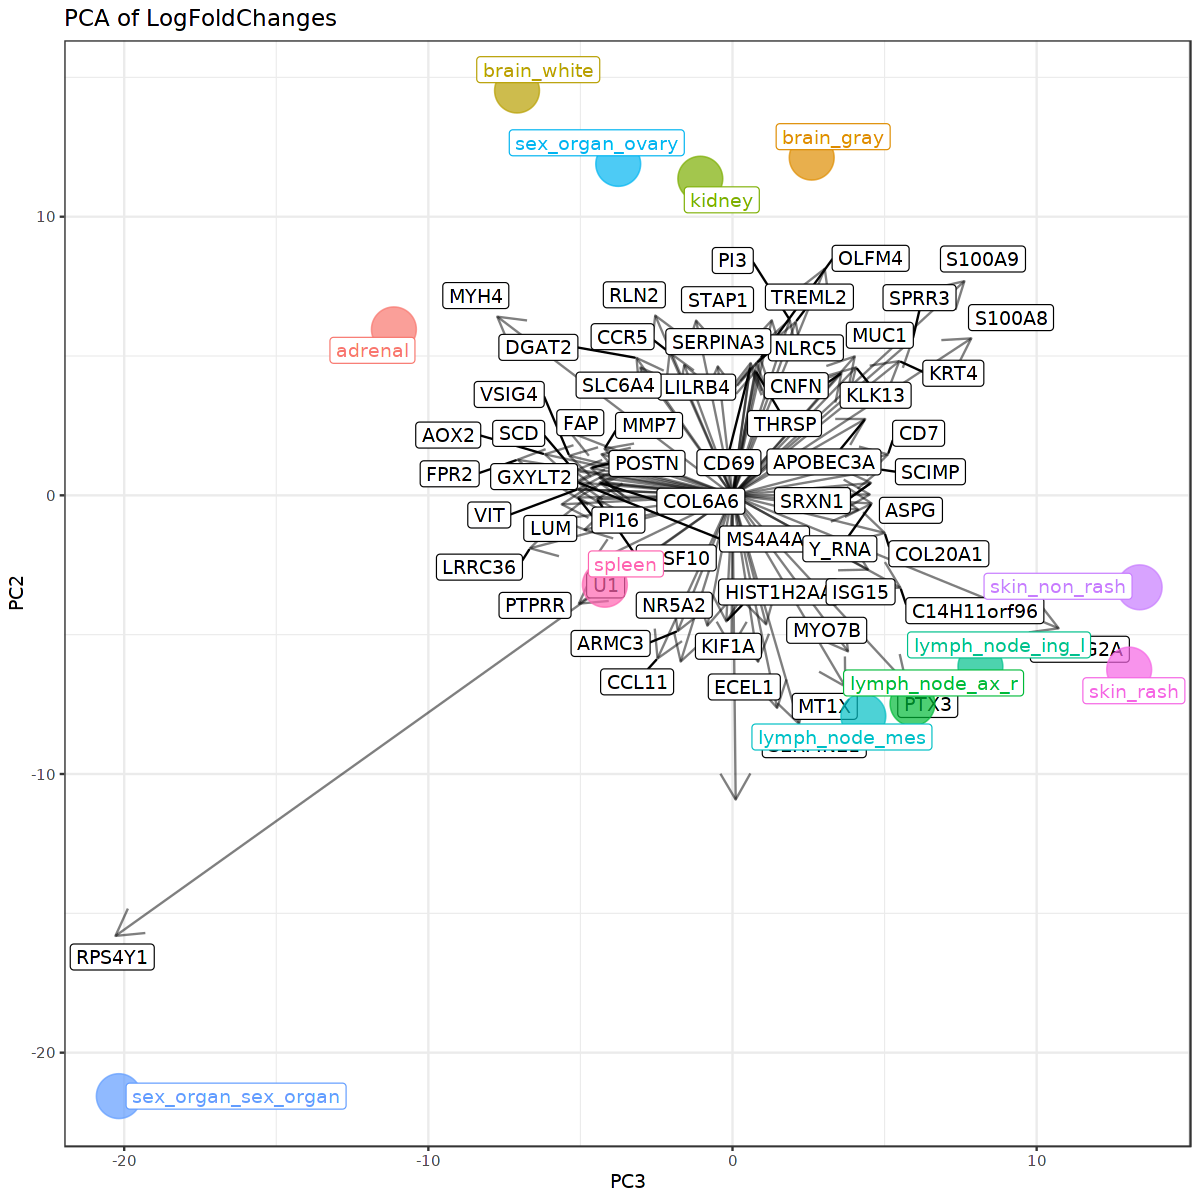

In [96]:
ggplot(plot.df, aes(color=tissue, x=PC3, y=PC2)) + 
    theme_bw() + 
    geom_segment(
        alpha=0.5,
        arrow = arrow(),
        data=loaded.genes.df,
        aes(x=0,y=0,xend=PC3*loading_scale,yend=PC2*loading_scale),inherit.aes=F
    ) +   ggtitle('PCA of LogFoldChanges') +
    geom_label_repel(data=loaded.genes.df,aes(x=PC3*loading_scale,y=PC2*loading_scale,label=symbol),inherit.aes=F,max.overlaps=100) +
    geom_point(size=12, alpha=0.7) +
    geom_label_repel(aes(label=tissue)) +
    theme(legend.position = 'none')

## PC3 vs PC4

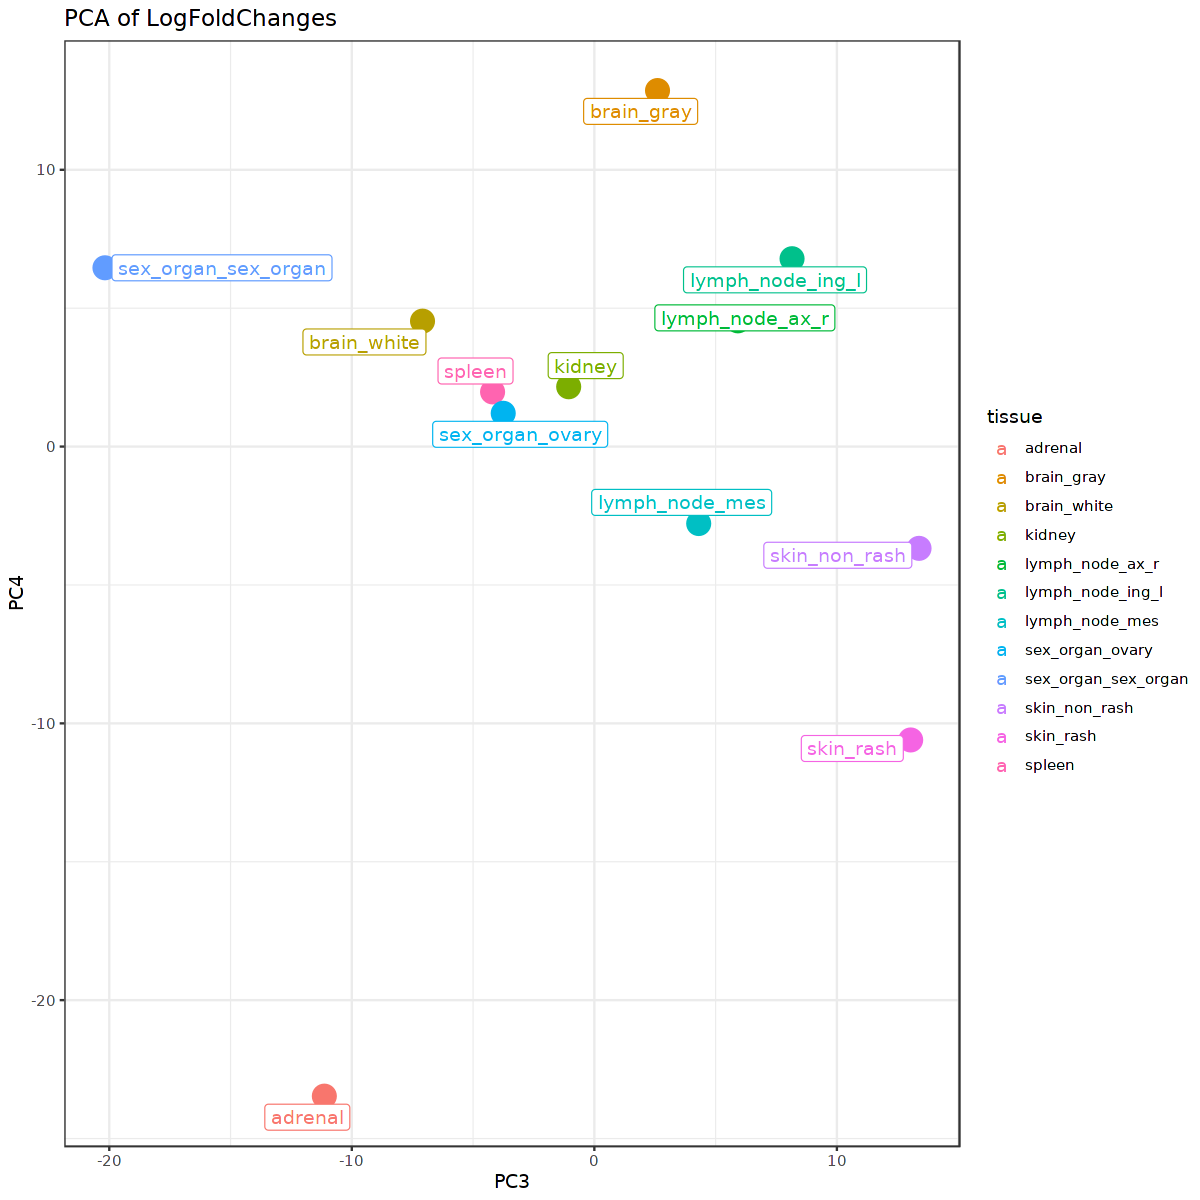

In [100]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(plot.df, aes(color=tissue, x=PC3, y=PC4)) + 
    geom_point(size=6) + 
    theme_bw() + 
    geom_label_repel(aes(label=tissue)) + 
    ggtitle('PCA of LogFoldChanges')